In [1]:
import torch.nn as nn
from GRU_pipeline import DataHolder, paths, dicDataset, GRUModel, pad_collate, HierarchicalDataset, Pipeline

DH = DataHolder(**paths)
#HD = HierarchicalDataset(DH)
#dl = HD.dataloader()
#DH.openface_tensor[1] = DH.openface_tensor[1]/5
#DH.openface_tensor[2] = DH.openface_tensor[2]/5

In [2]:
output = DH.make_train_test_datasets(test_size = .15, val_size = .17)
class_weights = output['class_weights']
openface_1  = output['datasets']['openface_1']
openface_2  = output['datasets']['openface_2']
#opensmile_1 = output['datasets']['opensmile_1']
#opensmile_2 = output['datasets']['opensmile_2']

Training on cpu
loss epoch 16: 1.988226
loss epoch 32: 1.931266
loss epoch 48: 1.921225
loss epoch 64: 1.899534
loss epoch 80: 1.889081


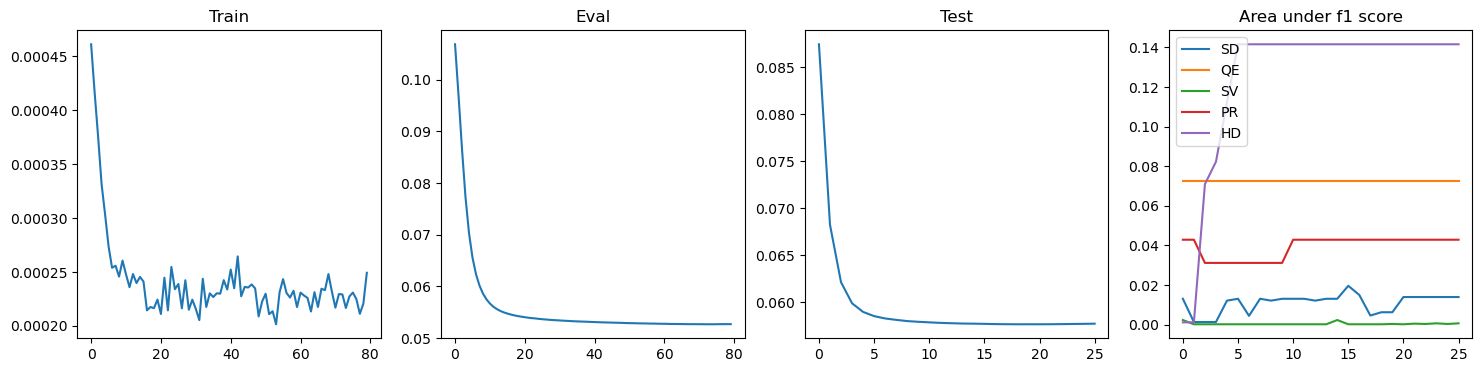

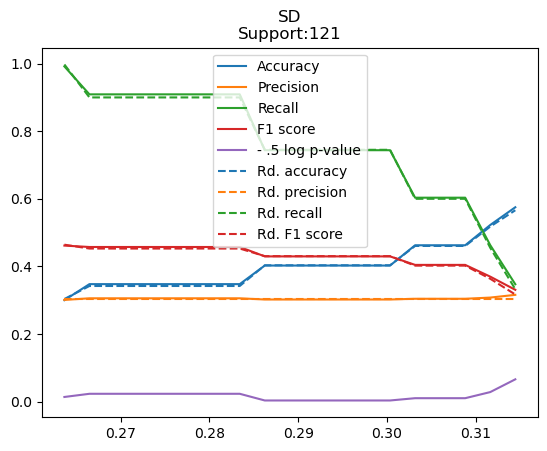

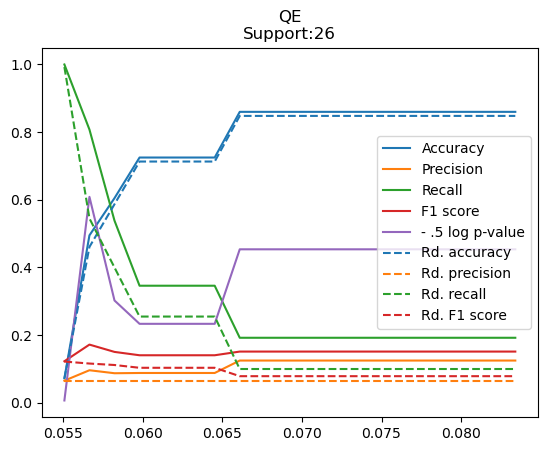

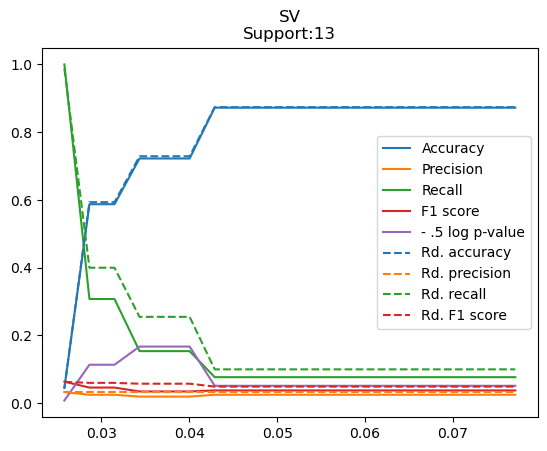

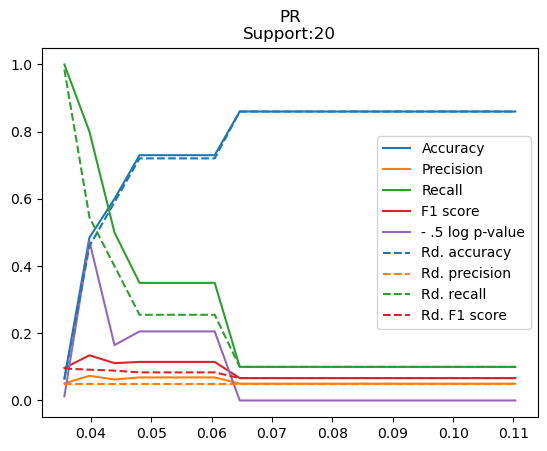

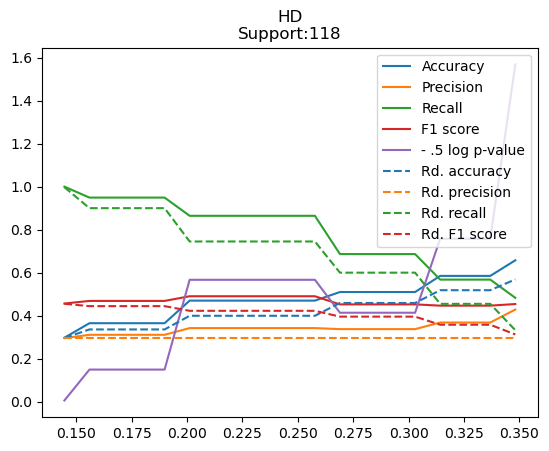

[0.01391732283464564,
 0.07272727272727272,
 0.0007965686274509776,
 0.04285714285714286,
 0.14155378486055775]

In [3]:
#MSE
model_args = {
    'input_dim':17,
    'hidden_dim':8,
    'layer_dim':8,
    'output_dim':5,
    'dropout_prob':.1
}

mseloss = nn.MSELoss()
def my_loss(pred, true):
    return mseloss(pred, 3*true)

args={
    'model': GRUModel(**model_args),
    'features_1':openface_1,
    'features_2':openface_2,
    #'features_1':opensmile_1,
    #'features_2':opensmile_2,
    #'criterion':nn.L1Loss()#weight=class_weights)
    #'criterion':nn.KLDivLoss(reduction='batchmean')
    #'criterion':my_loss
    'criterion':nn.MSELoss()
    #'criterion':nn.BCELoss()
    #'criterion':nn.MultiLabelMarginLoss()
    #'criterion':nn.MultiLabelSoftMarginLoss()

}
pipe = Pipeline(**args)
pipe.train(epoch=80,lr=1e-3, early_stop=False)
pipe.plot_losses()
pipe.eval_model(plot=True)

Training on cpu
loss epoch 16: 6.437305
loss epoch 32: 6.209087
loss epoch 48: 6.182469
loss epoch 64: 6.154581
loss epoch 80: 6.135435


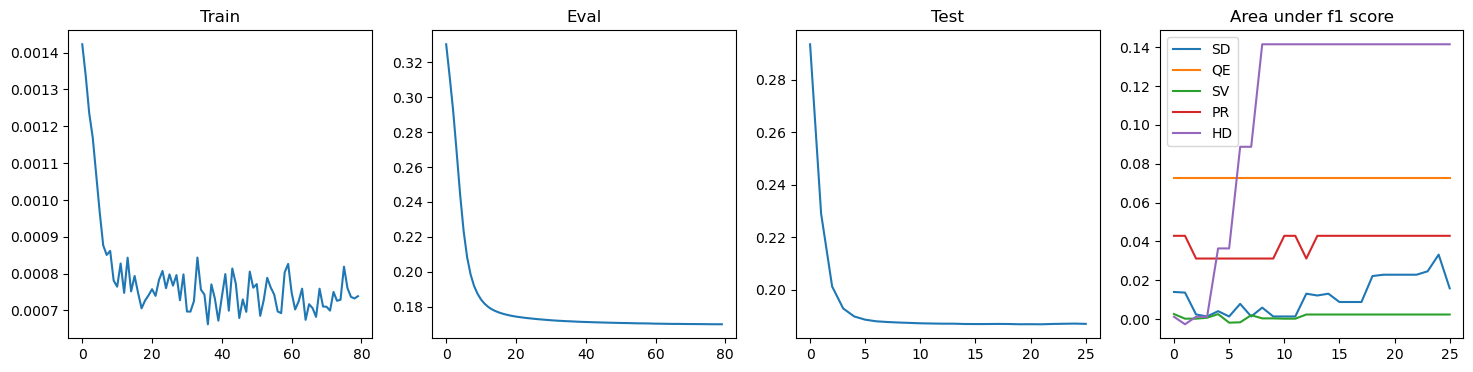

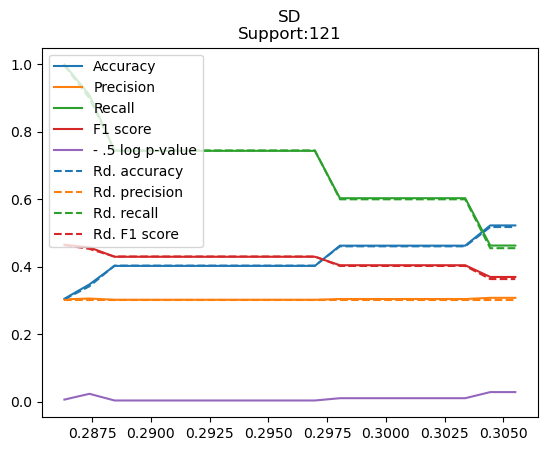

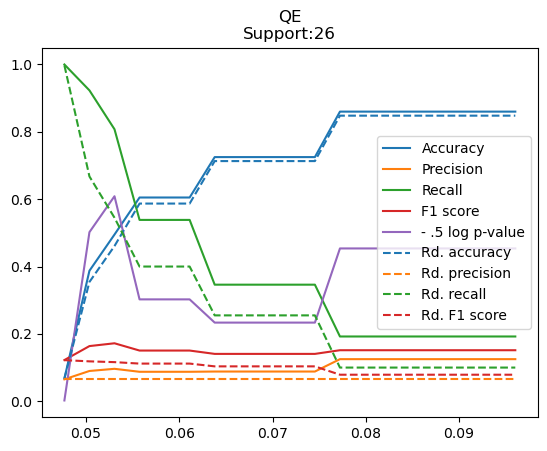

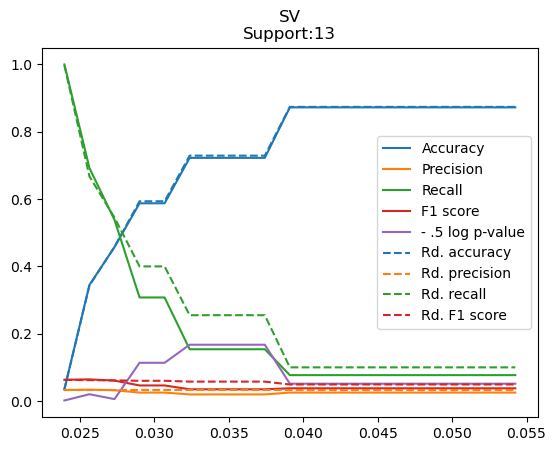

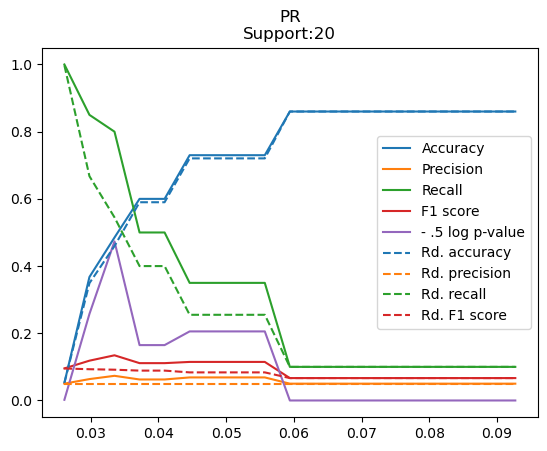

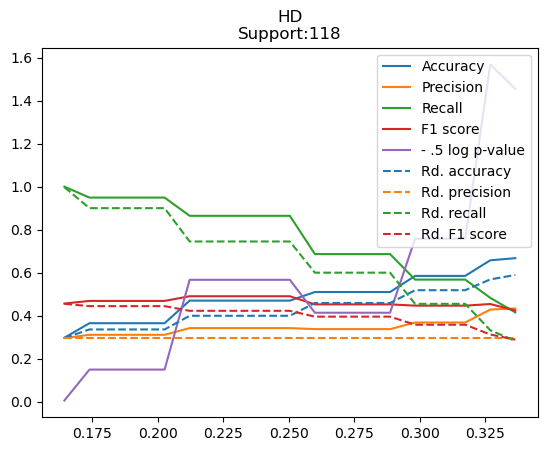

[0.006237623762376299,
 0.07272727272727272,
 0.0023035714285714257,
 0.04285714285714286,
 0.14155378486055775]

In [4]:
#BCE
model_args = {
    'input_dim':17,
    'hidden_dim':8,
    'layer_dim':8,
    'output_dim':5,
    'dropout_prob':.1
}

mseloss = nn.MSELoss()
def my_loss(pred, true):
    return mseloss(pred, 3*true)

args={
    'model': GRUModel(**model_args),
    'features_1':openface_1,
    'features_2':openface_2,
    #'features_1':opensmile_1,
    #'features_2':opensmile_2,
    #'criterion':nn.L1Loss()#weight=class_weights)
    #'criterion':nn.KLDivLoss(reduction='batchmean')
    #'criterion':my_loss
    #'criterion':nn.MSELoss()
    'criterion':nn.BCELoss()
    #'criterion':nn.MultiLabelMarginLoss()
    #'criterion':nn.MultiLabelSoftMarginLoss()

}
pipebce = Pipeline(**args)
pipebce.train(epoch=80,lr=1e-3, early_stop=False)
pipebce.plot_losses()
pipebce.eval_model(plot=True)

In [5]:
4*4*4*5

320

### Compare classifier to randomness ###

Let our problem be a binary classification ($0$: negative; $1$: positive) with positive class of probability $p\in (0,1)$.

We sample $N$ points.

Since it is binomial we'll consider that if we put our points in a ```y = np.array``` then ```y.mean()``` is a good estimator of $p$ (the proportion? Isn't it simpler to say that we take the proportion as p?).

We have a classifier that outputs probabilities in $(0,1)$ and we want to measure its relevance. There exist a wide range of classical metrics but since our data is highly imabalanced, it is impossible to make any sence of them. Additionnaly, most of these metrics depend on the threshold you pick, and due to imbalance, choosing the threshold that yields the highest metric does not necessarily garantee the relevance of the model. Therefore, our objective is to compare our model to randomness with either _any_ threshold or for _all_ thresholds.

To compare it with randomness, I assume that if our classifier is random, the actual label of any point is independant of the output of the model. I only need to calculate expected TP, FP, TN, and FN for a given threshold $t \in (0,1)$ to calculate the metrics and compare that to the performance of our model.



I chose the following method:

I gather all my samples ```y``` and all the outputs of our model ```y_pred```.

To estimate the performance of our model, for each threshold $t \in (0,1)$, I compute the metrics from ```sklearn.metrics``` package ```accuracy_score, precision_score, recall_score, f1_score``` between ```y``` and ```np.where(y_pred>t,1,0)``` (which converts outputs to $1$ or $0$). Note that these metrics can all be computed with y positive (TP), false positive (FP), true negative (TN), and false negative (FN).

We have a proportion of ```a_t = np.where(y_pred>t,1,0).mean()``` predicted positive. Among them, a proportion of about $P(y=1|y\_pred=1) = P(y=1)=p$ are TP since the actual labels are independant from the predicted ones. Therefore, $TP = N*a_t*p$, and since the metric I want are ratios, I can divide it right away by $N$, which gives me $TP = a_t*p$.

Similarly, I can calculate that:
- $FP = a_t*(1-p)$
- $TN = (1-a_t)*(1-p)$
- $FN = (1-a_t)*p$

Having:
- $accuracy = (TP+TN)/(TP+FP+FN+TN)$
- $precision = TP/(TP+FP)
- $recall = TP/(TP+FN)
- $f1 = 2 \frac{precision *recall}{precision + recall}$

We get after simplifications that:
- $a_t*(2*p-1) + 1 - p$
- $p$
- $a_t$
- $2\frac{p*a_t}{p + a_t}$

Which gives two curbs for each metric that allow to compare the model predictions to 'randomness'. I can derive a aggragated metrics from this, which I chose to be the average distance between random f1_score and actual f1_score.

Unfortunately, this method cannot select the best threshold w.r.t. model vs randomness. So I use the classic $\chi$-square test in its interpretation of "how likely are these results given that these two set of samples are supposedly from two independant laws". I think the way we process our data makes it legitimate w.r.t. the required assumptions (independance and randomness).

Therefore, for each threshold $t$, I also compute: ```sklearn.feature_selection.chi2( np.where(y_pred>t,1,0).reshape(-1,1) , y )[1][0]```

All-in-all, the code looks like this:

```python
def simulate_randomness(true, y_pred):
    tresh = np.linspace(y_pred.min(),y_pred.max(),20) #because I want this to be visually clear and not shrinked because all outputs are between .9 and .91
    p=y.sum()/y.shape[0]
    func = lambda t : np.where(y_pred > t,1,0).mean() #a_t
    out = [(
        func(t)*(2*p-1) + 1 - p,
        p,
        func(t),
        (2*p*func(t)) / (p + func(t)) if func(t) > 0 else np.nan
    ) for t in tresh[:-1]] #see below
    out = pd.DataFrame(out, columns=['Rd. accuracy', 'Rd. precision', 'Rd. recall', 'Rd. F1 score'], index=tresh[:-1])
    return out

def explore_tresh(y, y_pred):
    prop=y.sum()/y.shape[0]
    tresh = np.linspace(y_pred.min(),y_pred.max(),20)
    out = [(
        accuracy_score(y, np.where(y_pred>t,1,0)),
        precision_score(y, np.where(y_pred>t,1,0), zero_division=1),
        recall_score(y, np.where(y_pred>t,1,0)),
        f1_score(y, np.where(y_pred>t,1,0)),
        chi2( np.where(y_pred>t,1,0).reshape(-1,1) , y )[1][0]
    ) for t in tresh[:-1]] # don't take the last one otherwise precision can't be computed
    out = pd.DataFrame(out, columns=['Accuracy', 'Precision', 'Recall', 'F1 score', '- .5 log p-value'], index=tresh[:-1])
    out['- .5 log p-value'] = - np.log10(out['- .5 log p-value']) / 2
    return out

#--- y = ..., y_pred = ... ---#

rd = simulate_randomness(y,y_pred)
res = explore_tresh(y,y_pred)

f1_agg_score = (res['F1 score'].values - rd['Rd. F1 score'].values).mean()

ax = res.plot( color =list(mcolors.TABLEAU_COLORS.values()) )
rd.plot( ax=ax, linestyle='dashed',color =list(mcolors.TABLEAU_COLORS.values()) )
plt.show()
```

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('results_colab.csv')
df = df.astype({'hidden_dim':str, 'layer_dim':str, 'dropout':str})
df.head(2)

,loss,hidden_dim,layer_dim,dropout,residxSD,residxQE,residxSV,residxPR,residxHD,residexTL,resvalSD,resvalQE,resvalSV,resvalPR,resvalHD,resvalTL
0,MSELoss(),4,2,0.1,29,1,4,25,29,29,0.022,-0.014,0.030,0.152,0.036,0.058
1,MSELoss(),4,2,0.1,0,1,7,20,1,29,0.034,0.000,0.027,0.143,-0.031,0.058


In [86]:
df = pd.get_dummies(df)
resval_cols = ['resvalSD', 'resvalQE', 'resvalSV', 'resvalPR', 'resvalHD']
hidden_dim_col = ['hidden_dim_16', 'hidden_dim_32','hidden_dim_4', 'hidden_dim_8'] # high card = wider, low card = narrow
layer_dim_col = ['layer_dim_16', 'layer_dim_2','layer_dim_4', 'layer_dim_8'] # high card = shallow, low card = deep wtf
loss_col=['loss_BCELoss()', 'loss_MSELoss()'] # no influence let alone shitty columns where it's BCE
dropout_col = ['dropout_0.1', 'dropout_0.2'] # no influence or .1 better
df.columns

Index(['residxSD', 'residxQE', 'residxSV', 'residxPR', 'residxHD', 'residexTL',
       'resvalSD', 'resvalQE', 'resvalSV', 'resvalPR', 'resvalHD', 'resvalTL',
       'loss_BCELoss()', 'loss_MSELoss()', 'hidden_dim_16', 'hidden_dim_32',
       'hidden_dim_4', 'hidden_dim_8', 'layer_dim_16', 'layer_dim_2',
       'layer_dim_4', 'layer_dim_8', 'dropout_0.1', 'dropout_0.2'],
      dtype='object')

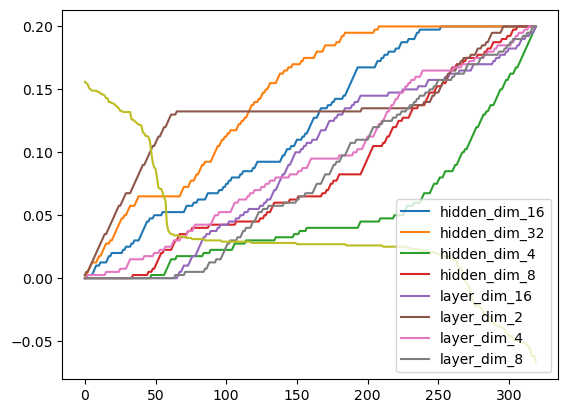

In [88]:
col = 'resvalSD'
(df.sort_values(by=col, ascending=False)[hidden_dim_col + layer_dim_col].cumsum().reset_index(drop=True)/400).plot()
plt.plot(df[col].sort_values(ascending=False).reset_index(drop=True))
plt.show()

In [84]:
df.groupby(['layer_dim', 'hidden_dim'])[resval_cols].agg(['mean', 'max'])